Data source: https://datashare.is.ed.ac.uk/handle/10283/392
Code from: https://haythamfayek.com/2016/04/21/speech-processing-for-machine-learning.html

In [1]:
import numpy as np
import scipy.io.wavfile
from scipy.fftpack import dct

In [4]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 15})

In [5]:
data_folder = 'data/dataset_arthur-the-rat/'
path1 = data_folder + 'Arthur the Rat (recordings 476-500)/R0482.wav'
#path2 = data_folder + 'Arthur the Rat (recordings 476-500)/R0483.wav'
path2 = data_folder + 'Audio test/OSR_us_000_0010_8k.wav'

In [6]:
def load_audio(path):
    sample_rate, signal = scipy.io.wavfile.read(path)
    print('Sample Rate is %d Hz' % sample_rate)
    print('Total length is %.1f seconds' %(len(signal)/sample_rate))
    time = np.arange(len(signal))/sample_rate
    return sample_rate, signal, time

print('Audio file 1:')
sample_rate1, signal1, time1 = load_audio(path1)
print('Audio file 2:')
sample_rate2, signal2, time2 = load_audio(path2)

Audio file 1:
Sample Rate is 48000 Hz
Total length is 132.5 seconds
Audio file 2:
Sample Rate is 8000 Hz
Total length is 33.6 seconds


In [7]:
def select_time(sample_rate, signal, time, start = 0, end = 3.5):
    selected_signal = signal[int(sample_rate * start):int(sample_rate * end)]
    selected_time   = time[int(sample_rate * start):int(sample_rate * end)]
    return selected_signal, selected_time

In [8]:
print('Recording 1,  input time range: %.2f s - %0.2f s' %(time1[0], time1[-1]))
signal1, time1 = select_time(sample_rate1, signal1, time1, 0, 5)
print('Recording 1, output time range: %.2f s - %0.2f s' %(time1[0], time1[-1]))
print()
print('Recording 2,  input time range: %.2f s - %0.2f s' %(time2[0], time2[-1]))
signal2, time2 = select_time(sample_rate2, signal2, time2, 0, 5)
print('Recording 2, output time range: %.2f s - %0.2f s' %(time2[0], time2[-1]))

Recording 1,  input time range: 0.00 s - 132.55 s
Recording 1, output time range: 0.00 s - 5.00 s

Recording 2,  input time range: 0.00 s - 33.62 s
Recording 2, output time range: 0.00 s - 5.00 s


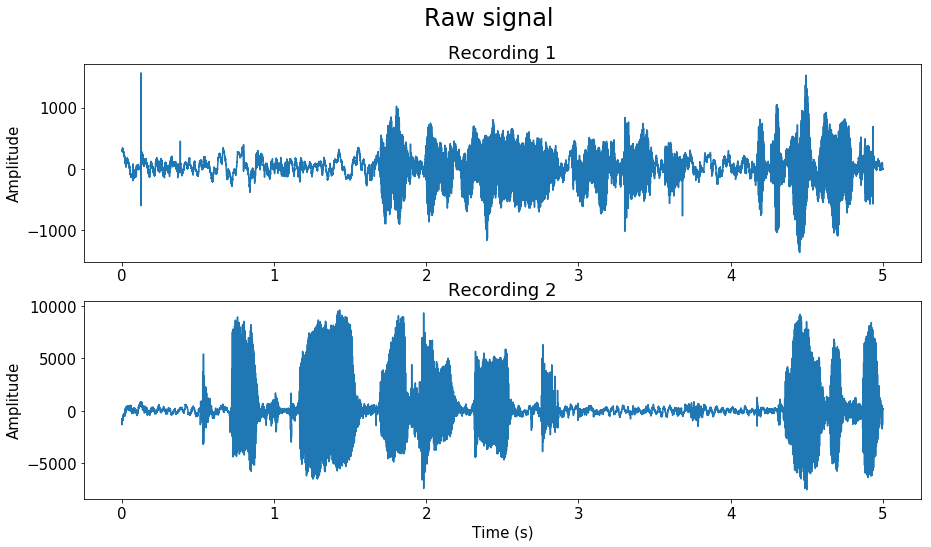

In [9]:
f = plt.figure(figsize = (15,8))
_ = f.suptitle('Raw signal', fontsize = 24)

_ = plt.subplot(2,1,1)
_ = plt.plot(time1,signal1)
_ = plt.ylabel('Amplitude')
_ = plt.title('Recording 1')

_ = plt.subplot(2,1,2)
_ = plt.plot(time2,signal2)
_ = plt.xlabel('Time (s)')
_ = plt.ylabel('Amplitude')
_ = plt.title('Recording 2')


In [10]:
pre_emphasis = 0.97
emphasized_signal1 = np.append(signal1[0], signal1[1:] - pre_emphasis * signal1[:-1])
emphasized_signal2 = np.append(signal2[0], signal2[1:] - pre_emphasis * signal2[:-1])

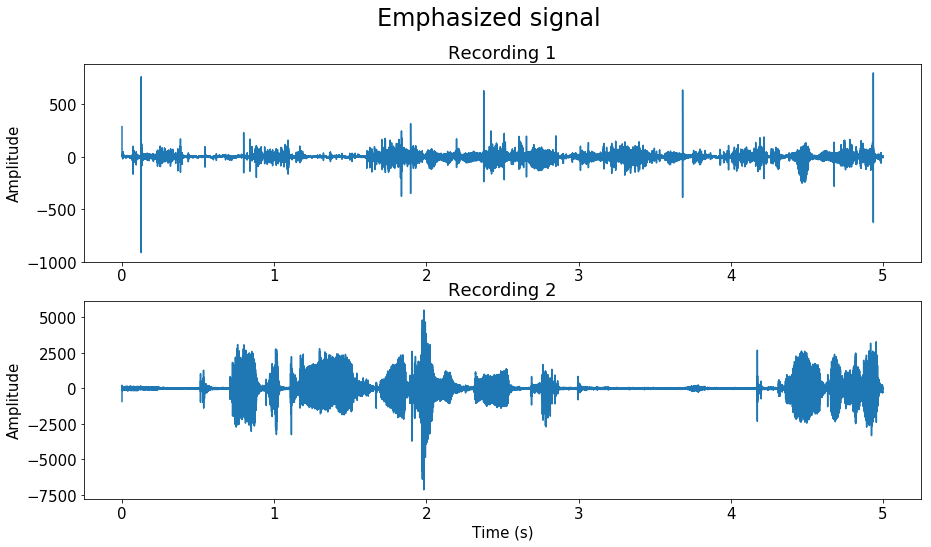

In [11]:
f = plt.figure(figsize = (15,8))
_ = f.suptitle('Emphasized signal', fontsize = 24)

_ = plt.subplot(2,1,1)
_ = plt.plot(time1,emphasized_signal1)
_ = plt.ylabel('Amplitude')
_ = plt.title('Recording 1')

_ = plt.subplot(2,1,2)
_ = plt.plot(time2,emphasized_signal2)
_ = plt.xlabel('Time (s)')
_ = plt.ylabel('Amplitude')
_ = plt.title('Recording 2')


In [12]:
def framing_and_window(signal, sample_rate, frame_size = 0.025, frame_stride = 0.01, start_time = 0):
    frame_length, frame_step = frame_size * sample_rate, frame_stride * sample_rate  # Convert from seconds to samples
    signal_length = len(signal)
    frame_length = int(round(frame_length))
    frame_step = int(round(frame_step))
    num_frames = int(np.ceil(float(np.abs(signal_length - frame_length)) / frame_step))  # Make sure that we have at least 1 frame

    pad_signal_length = num_frames * frame_step + frame_length
    z = np.zeros((pad_signal_length - signal_length))
    pad_signal = np.append(signal, z) # Pad Signal to make sure that all frames have equal number of samples without truncating any samples from the original signal

    indices = np.tile(np.arange(0, frame_length), (num_frames, 1)) + np.tile(np.arange(0, num_frames * frame_step, frame_step), (frame_length, 1)).T
    frames = pad_signal[indices.astype(np.int32, copy=False)]
    frames *= np.hamming(frame_length)
    frame_times = np.arange(frames.shape[0]) * frame_stride + start_time # convert back to seconds
    return frames, frame_times

In [13]:
frames1, frame_times1 = framing_and_window(emphasized_signal1, sample_rate1, start_time = time1[0])
frames2, frame_times2 = framing_and_window(emphasized_signal2, sample_rate2, start_time = time2[0])
print(emphasized_signal1.shape, time1.shape, frames1.shape, frame_times1.shape)
print(emphasized_signal2.shape, time2.shape, frames2.shape, frame_times2.shape)

(240000,) (240000,) (498, 1200) (498,)
(40000,) (40000,) (498, 200) (498,)


In [14]:
def fourier_and_power(frames, NFFT = 512):
    mag_frames = np.absolute(np.fft.rfft(frames, NFFT))  # Magnitude of the FFT
    pow_frames = ((1.0 / NFFT) * ((mag_frames) ** 2))  # Power Spectrum
    return mag_frames, pow_frames

In [15]:
mag_frames1, pow_frames1 = fourier_and_power(frames1)
mag_frames2, pow_frames2 = fourier_and_power(frames2)
print('Magnitude and power shape recording 1:', mag_frames1.shape, pow_frames1.shape)
print('Magnitude and power shape recording 2:', mag_frames2.shape, pow_frames2.shape)

Magnitude and power shape recording 1: (498, 257) (498, 257)
Magnitude and power shape recording 2: (498, 257) (498, 257)


In [16]:
def filter_banks(pow_frames, sample_rate, nfilt = 40, NFFT = 512):
    low_freq_mel = 0
    high_freq_mel = (2595 * np.log10(1 + (sample_rate / 2) / 700))  # Convert Hz to Mel
    mel_points = np.linspace(low_freq_mel, high_freq_mel, nfilt + 2)  # Equally spaced in Mel scale
    hz_points = (700 * (10**(mel_points / 2595) - 1))  # Convert Mel to Hz
    bin = np.floor((NFFT + 1) * hz_points / sample_rate)

    fbank = np.zeros((nfilt, int(np.floor(NFFT / 2 + 1))))
    for m in range(1, nfilt + 1):
        f_m_minus = int(bin[m - 1])   # left
        f_m = int(bin[m])             # center
        f_m_plus = int(bin[m + 1])    # right

        for k in range(f_m_minus, f_m):
            fbank[m - 1, k] = (k - bin[m - 1]) / (bin[m] - bin[m - 1])
        for k in range(f_m, f_m_plus):
            fbank[m - 1, k] = (bin[m + 1] - k) / (bin[m + 1] - bin[m])
    filter_banks = np.dot(pow_frames, fbank.T)
    filter_banks = np.where(filter_banks == 0, np.finfo(float).eps, filter_banks)  # Numerical Stability
    filter_banks = 20 * np.log10(filter_banks)  # dB
    return filter_banks

In [17]:
def mfcc(filter_banks, num_ceps = 12, sinu_lift = True):
    mfcc = dct(filter_banks, type=2, axis=1, norm='ortho')[:, 1 : (num_ceps + 1)] # Keep 2-13
    if sinu_lift:
        (nframes, ncoeff) = mfcc.shape
        n = np.arange(ncoeff)
        lift = 1 + (cep_lifter / 2) * np.sin(np.pi * n / cep_lifter)
        mfcc *= lift
    return mfcc

def mean_norm(filter_banks):
    filter_banks -= (np.mean(filter_banks, axis=0) + 1e-8)
    return filter_banks

In [18]:
filter_banks1 = mean_norm(filter_banks(pow_frames1, sample_rate1))
filter_banks2 = mean_norm(filter_banks(pow_frames2, sample_rate2))
print('Filter banks shape recording 1:', filter_banks1.shape)
print('Filter banks shape recording 2:', filter_banks2.shape)

Filter banks shape recording 1: (498, 40)
Filter banks shape recording 2: (498, 40)


In [19]:
mfcc1 = mean_norm(mfcc(filter_banks(pow_frames1, sample_rate1), num_ceps = 12, sinu_lift = False))
mfcc2 = mean_norm(mfcc(filter_banks(pow_frames2, sample_rate2), num_ceps = 12, sinu_lift = False))
print('MFCC shape recording 1:', mfcc1.shape)
print('MFCC shape recording 2:', mfcc2.shape)

MFCC shape recording 1: (498, 12)
MFCC shape recording 2: (498, 12)


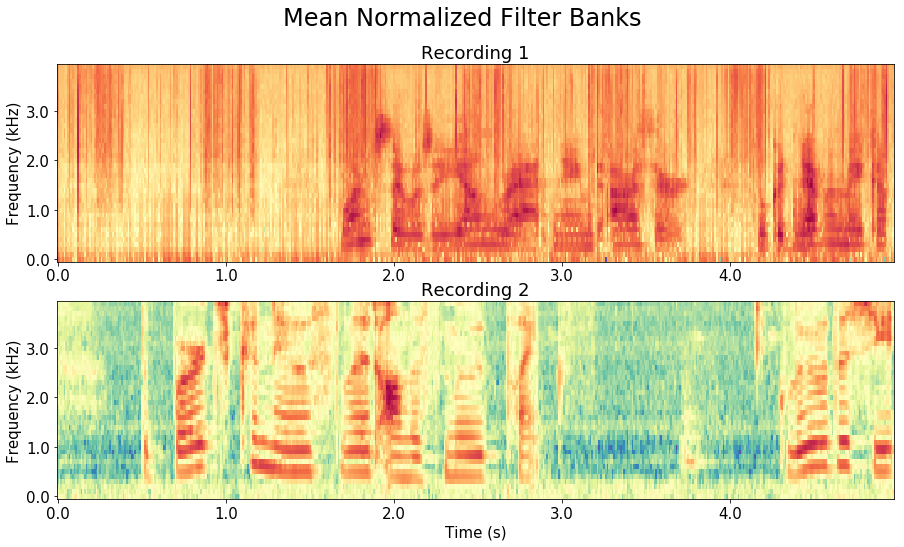

In [20]:
def fix_ticks(actual, step = 1, n_labels = None, axis = 0):
    # Function to re-label x (axis == 0) or y (axis == 1) ticks when using imshow
    # actual is an array of the same length as the number of pixels along the axis
    # step is the numerical distance between ticks in the units of actual
    # alternately, n_labels is the number of labels to use - they will be evenly spaced
    
    n_pixels = len(actual)
    tick_range = actual[-1] - actual[0]
    if n_labels is not None:
        tick_step = int(n_pixels/n_labels)
    else:
        tick_step = int(n_pixels/(tick_range/step))
    positions = np.arange(0,n_pixels,tick_step) # pixel count at label position
    labels = actual[::tick_step] # labels you want to see
    if axis == 0:
        plt.xticks(positions, labels)
    else:
        plt.yticks(positions, labels)

f = plt.figure(figsize = (15,8))
_ = f.suptitle('Mean Normalized Filter Banks', fontsize = 24)
y = np.arange(filter_banks1.shape[1])/10

_ = plt.subplot(2,1,1)
_ = plt.imshow(filter_banks1.T, cmap = 'Spectral_r', aspect = 'auto', origin='lower') 
_ = plt.ylabel('Frequency (kHz)')
_ = fix_ticks(frame_times1, step = 1, axis = 0)
_ = fix_ticks(y, step = 1, axis = 1)
_ = plt.title('Recording 1')

_ = plt.subplot(2,1,2)
_ = plt.imshow(filter_banks2.T, cmap = 'Spectral_r', aspect = 'auto', origin='lower')
_ = plt.xlabel('Time (s)')
_ = plt.ylabel('Frequency (kHz)')
_ = fix_ticks(frame_times1, step = 1, axis = 0)
_ = fix_ticks(y, step = 1, axis = 1)
_ = plt.title('Recording 2')

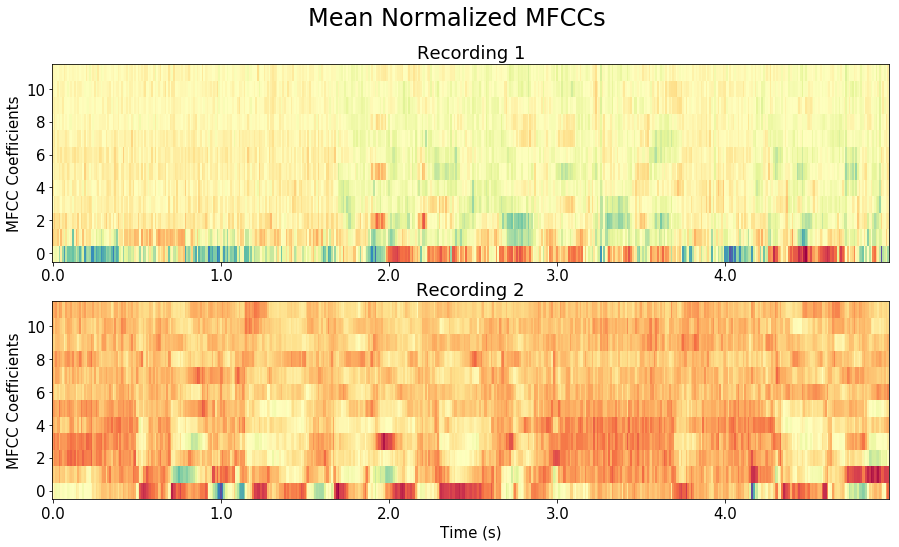

In [21]:
f = plt.figure(figsize = (15,8))
_ = f.suptitle('Mean Normalized MFCCs', fontsize = 24)

_ = plt.subplot(2,1,1)
_ = plt.imshow(mfcc1.T, cmap = 'Spectral_r', aspect = 'auto', origin='lower') 
_ = plt.ylabel('MFCC Coefficients')
_ = fix_ticks(frame_times1, step = 1, axis = 0)
_ = plt.title('Recording 1')

_ = plt.subplot(2,1,2)
_ = plt.imshow(mfcc2.T, cmap = 'Spectral_r', aspect = 'auto', origin='lower')
_ = plt.xlabel('Time (s)') 
_ = plt.ylabel('MFCC Coefficients')
_ = fix_ticks(frame_times1, step = 1, axis = 0)
_ = plt.title('Recording 2')